# JAX Scratch Code
For learning and experimenting with JAX

In [ ]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)


In [21]:
# %% Set up other imports
import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

In [18]:
# %% Electron cyclotron motion test

# Mass, charge, and magnetic field strength
Params = namedtuple('Params', ['m', 'q', 'b0'])

def f_slab(state, t, params: Params):
    """
    ODE function for electron cyclotron motion in a uniform magnetic field.

    state: (x,p) pytree with x,p shape (N,3)
    """
    x, p = state

    dxdt = p / params.m
    dpdt = params.q * jnp.cross(p / params.m, params.b0)

    return (dxdt, dpdt)



# ---- PyTree helpers for RK4 ----
def tree_addmul(y, a, dy):
    # y + a * dy (for PyTrees with same structure)
    return jtu.tree_map(lambda yi, dyi: yi + a * dyi, y, dy)

def tree_lincomb(coeffs, trees):
    # sum_i coeffs[i] * trees[i]
    return jtu.tree_map(lambda *leaves: sum(c * l for c, l in zip(coeffs, leaves)), *trees)

## RK4 Stepper
def rk4_step(state, t, dt, rhs, params: Params):
    k1 = rhs(state                         , t         , params)
    k2 = rhs(tree_addmul(state, 0.5*dt, k1), t + 0.5*dt, params)
    k3 = rhs(tree_addmul(state, 0.5*dt, k2), t + 0.5*dt, params)
    k4 = rhs(tree_addmul(state,     dt, k3), t + dt    , params)
    incr = tree_lincomb([dt/6, dt/3, dt/3, dt/6], [k1, k2, k3, k4])
    return tree_addmul(state, 1.0, incr)

## Actual simulation function
@partial(jax.jit, static_argnames=['dt', 'steps'])
def simulate(x0, p0, params: Params, dt: float, steps: int):
    """
    Returns arrays of positions and velocities
    """
    state0 = (x0, p0)

    def body(state, i):
        t = i * dt
        new_state = rk4_step(state, t, dt, f_slab, params)
        return new_state, new_state

    # collect states at each step
    stateT, traj = jax.lax.scan(body, state0, jnp.arange(steps))
    # include initial state at index 0
    x_hist = jnp.concatenate([state0[0][None], traj[0]], axis=0)
    p_hist = jnp.concatenate([state0[1][None], traj[1]], axis=0)
    return x_hist, p_hist

In [26]:

# -------------------------------
# Example: single particle cyclotron orbit
# -------------------------------
if __name__ == "__main__":
    # Number of particles
    N = 1
    # Parameters
    params = Params(m=1.0, q=1.0, b0=jnp.array([0.0, 0.0, 1.0]))

    # Initial conditions: position (m), velocity (m/s)
    x0 = jnp.array([[1.0, 0.0, 0.0]])   # shape (N,3)
    v0 = jnp.array([[0.0, 1.0, 1.0]])   # perpendicular to B -> circular orbit

    # Time step and duration
    omega_c = 1.0
    T_c = 2 * jnp.pi / omega_c                             # period
    steps_per_period = 400                                 # finer -> better energy behavior
    dt = T_c / steps_per_period
    n_periods = 5
    steps = int(steps_per_period * n_periods)

    x_hist, v_hist = simulate(x0, v0, params, dt, steps)

    # Quick diagnostics: speed constancy (RK4 is not symplectic, so pick dt small)
    speeds = jnp.linalg.norm(v_hist[..., :], axis=-1)     # (steps+1, N)
    print("speed mean, std:", speeds.mean(), speeds.std())

speed mean, std: 1.414213562299334 4.2607419073609677e-11


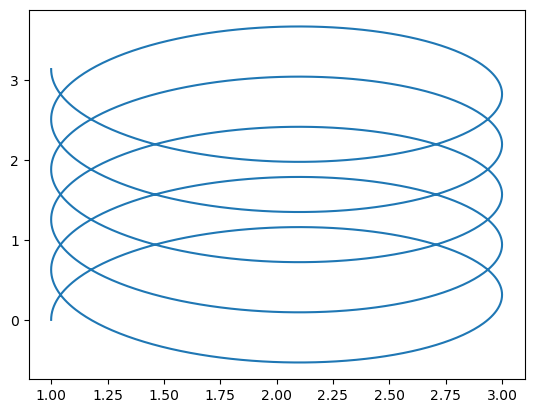

In [28]:
plt.figure()

plt.plot(x_hist[:,0,0], x_hist[:,0,1] + x_hist[:,0,2]*0.1)